In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate, ShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import eli5
import pandas as pd
import data 
from collections import Counter
import train
plt.style.use('dark_background')
# sns.set(style="white")
NUM_PATIENTS = 12044
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
# prep the dataframe
features = data.get_features() # uses several forms
outcomes = data.get_outcomes() # 2 outcomes: iai, and iai_intervention
df = pd.merge(features, outcomes, on='id', how='left')


# process the feats (should save into df)
X_feats_full = data.preprocess(features)
df = df[feat_names+ [outcome_def]].replace('True', 1).replace('False', 0)
'''
df = df.replace('nan', -1)
df = df.fillna(-1)
df = df.infer_objects()
df = df.astype(float).astype(int)
'''

# set up train / test
np.random.seed(42)
# 6 is the test set
df['cv_fold'] = np.random.randint(1, 7, size=df.shape[0])

# remove unusable features
ks = [k for k in X_feats_full.keys() if not k in ['id'] and not 'IAI' in k]
X_feats_full= X_feats_full[ks]

# get actual features
X_np = X_feats_full.values
feature_names = list(X_feats_full)
outcome_def = 'iai_intervention'
# y_np = outcomes['iai_intervention']

100%|██████████| 49/49 [00:01<00:00, 17.44it/s]
48it [00:05,  8.52it/s]


final shape (12044, 433)


# predict limited

In [3]:
feat_names = ['VomitWretch_1', 'RecodedMOI_1', 'GCSScore_1', 'ThoracicTender_1', 'ThoracicTrauma_1', 
          'Costal_1', 'DecrBreathSound_1', 'AbdDistention_1', 'AbdomenPain_1', 'AbdTenderDegree_1',
          'AbdTrauma_1', 'SeatBeltSign_1', 'DistractingPain_1']
# InjuryMechanism_1, hypotension?, femure fracture
ks = set()
for k_useful in feat_names:
    for k in feature_names:
        if k_useful in k:
            ks.add(k)
ks = np.array(list(ks))

In [ ]:
for balancing in ['none', 'ros']:
    for model_type in tqdm(['gb', 'logistic', 'dt', 'svm', 'rf', 'mlp2']):
        for num_feats in [4]: #, 9, 11, 23, 35]: #[23]:# [4, 6, 7, 9, 11]:
            feats = feat_names[:num_feats]
            out_dir = f'results/outcome={outcome_def}'
            os.makedirs(out_dir, exist_ok=True)
            out_name = f'{model_type}_{len(feat_names)}_{balancing}'
            train.train(df, feat_names=feats, model_type=model_type, balancing=balancing, outcome_def=outcome_def,
                        out_name=f'{out_dir}/{out_name}.pkl')

# predict full

In [9]:
X_feats_full.shape

(12044, 109)

# decision tree fitting

In [8]:
model_type='tree'
max_depth = 3
num_cv = 10

if model_type == 'tree':
    m = DecisionTreeClassifier(max_depth=max_depth, class_weight={0: 1, 1: 500})
elif model_type == 'logistic':
    m = LogisticRegressionCV(class_weight={0: 1, 1: 300}, cv=3, max_iter=100)
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
m_cv = cross_validate(m, X_train, y_train, cv=num_cv, scoring=['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'],
                      return_train_score=True, return_estimator=True)

In [9]:
# print('metric\ttrain\ttest')
for key in m_cv:
    if 'test' in key:
#         print(f"{key.replace('test_', '')}\t{np.mean(m_cv[key.replace('test', 'train')]):0.2f}\t{np.mean(m_cv[key]):0.2f}")
        print(f"{np.mean(m_cv[key]):0.2f}\t{key.replace('test_', '')}")

0.02	precision
0.98	recall
0.04	f1
0.56	balanced_accuracy
0.79	roc_auc


In [10]:
def count_common_feats(m_cv, model_type='tree'):
    if model_type == 'tree':
        feats_used = []
        for i in range(len(m_cv['estimator'])):
            m_fit = m_cv['estimator'][i]
            feats_used += list(ks[m_fit.feature_importances_ != 0])
    elif model_type == 'logistic':
        feats_used = []
        for i in range(len(m_cv['estimator'])):
            m_fit = m_cv['estimator'][i]
            num_feats = 5
            # get top num_feats features with biggest bsolute weights
            idxs = np.abs(m_fit.coef_).flatten().argsort()[-num_feats:][::-1]
            feats_used += list(ks[idxs])
    return sorted(dict(Counter(feats_used)).items(), key=lambda kv: kv[1], reverse=True)
        
count_common_feats(m_cv, model_type)

[('AbdTenderDegree_1_1.0', 10),
 ('AbdTrauma_1_2', 10),
 ('AbdomenPain_1_2', 10),
 ('RecodedMOI_1_2', 10),
 ('RecodedMOI_1_4', 7),
 ('DistractingPain_1_1', 7),
 ('SeatBeltSign_1_2', 1),
 ('ThoracicTender_1_1', 1),
 ('GCSScore_1', 1),
 ('AbdDistention_1_1', 1),
 ('VomitWretch_1_2', 1),
 ('AbdTrauma_or_SeatBeltSign_1_True', 1)]

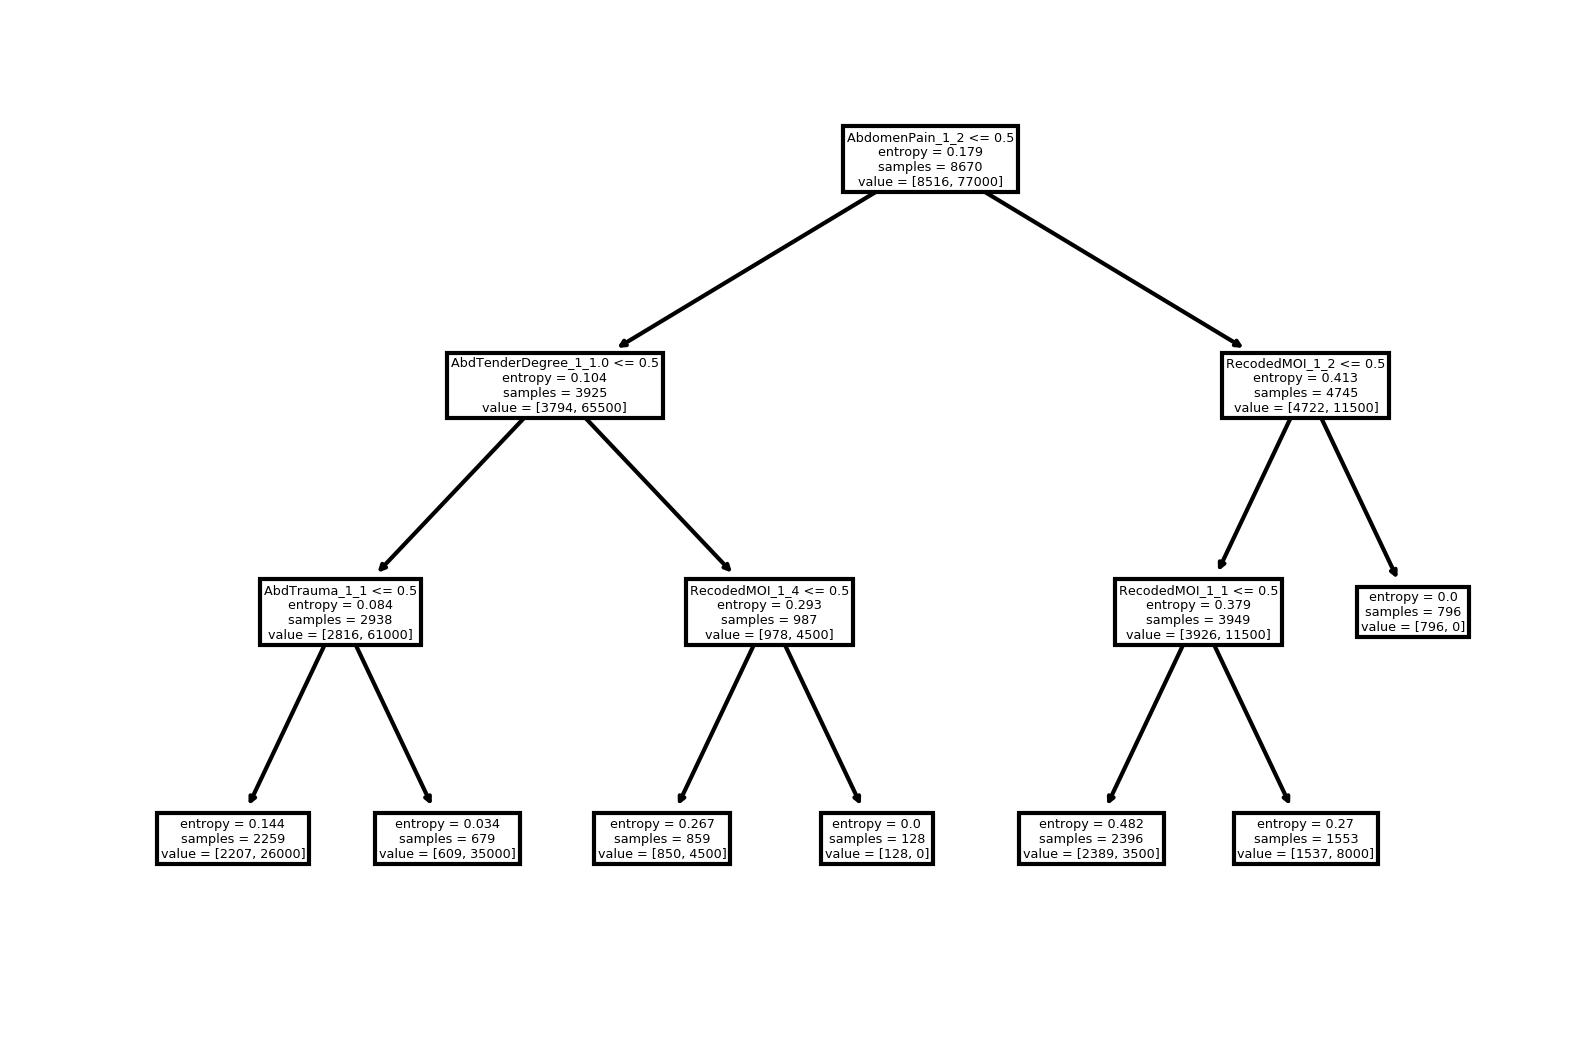

In [12]:
# plot a tree
m_fit = m_cv['estimator'][0]
plt.figure(dpi=300)
plot_tree(m_fit, feature_names=ks)
plt.show()